# Do the wavelength study for the hollow glass tube with polymer

Do it for both lossy and non-lossy polymer.  Both with air outside.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


from fiberamp.fiber.microstruct.bragg import BraggExact
from step_exact import plotlogf
from scipy.optimize import newton

importing NGSolve-6.2.2203-56-g47f483033


In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Wavelength Study Function

In [ ]:
def wl_study(s=0, d=4.0775e-05, L=1.4e-6, R=2e-6, n=300, verbose=False):
    """Perform wavelength study with polymer thickness d and loss s."""
    print('Performing wavelength study with polymer thickness %e and extinction coefficient %.4f\n\n' %(d, s),
         end='\r')
    wls = np.linspace(L, R, n+1)
    betas = np.zeros_like(wls, dtype=complex)
    outer = 'h2'
    nu = 1

    n_air = 1.00027717
    n_glass = 1.4388164768221814
    n_poly = 1.5 - s * 1j
    
    ts = [4.0775e-05, 1e-5, d, 3e-5]
    ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_poly, lambda x:n_air]
    mats = ['air','glass', 'polymer','air']
    maxhs = [10,10,10,10]
    
    for i, wl in enumerate(wls):
        if verbose:
            print(20 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
                  'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
        else:
            print(20 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + '  ' +  20 * '-' +5 * ' ',
                 end="\r")
            
        A = BraggExact(ts=ts, ns=ns , mats=mats,maxhs=maxhs, wl=wl)
        k_low = A.ks[0] * A.scale
        guess = np.array(.9999 * k_low)
        imag = 0
        flag = True
        reduce = 0

        while flag:
            try:
                x0 = np.array(guess + imag*1j)
                beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
                if beta.real > k_low:
                    if verbose:
                        print("Captured wrong mode, retrying.")
                    raise RuntimeError
                elif beta.imag > 0:
                    if verbose:
                        print("Positive imaginary part, retrying.")
                    imag = -beta.imag
                    guess *= 1/.999995
                    raise RuntimeError
                else:
                    if verbose:
                        print("Scaled beta: ", beta, ". Residual of determinant: ", 
                              abs(A.determinant(beta, nu, outer)), '\n\n' )
                    imag = beta.imag
                    flag=False
            except RuntimeError:
                guess *= .999995
                reduce += 1
                if verbose:
                    print("scaling guess: " + str(reduce), flush=True)
        betas[i] = beta
    return betas, wls
    

# Run multiple loss studies at varying thickness

In [ ]:
Ss = [0, .001, .005, .01]
D = 4.0775e-05
Ds = [.25 * D, .5 * D, D, 1.5 * D]
n = 300

results = np.zeros((len(Ds), len(Ss), n+1), dtype=complex)

In [ ]:
for i in range(len(Ds)):
    for j in range(len(Ss)):
        results[i,j,:], _ = wl_study(d=Ds[i], s=Ss[j], n=n)

In [ ]:
np.save('results', results)
np.save('Ds', Ds)
np.save('Ss', Ss)

# Comparison Graph

In [5]:
import numpy as np
import matplotlib.pyplot as plt

results_loaded = np.load('data/results.npy')
Ds_loaded = np.load('data/Ds.npy')
Ss_loaded = np.load('data/Ss.npy')

In [6]:
def graph(results, Ds, Ss, L=1.4e-6, R=2e-6, figsize=(14,12), n_row=2):
    d_len, s_len = len(Ds), len(Ss)
    n = results.shape[-1] # Get number of thicknesses and loss values in total
    
    wls = np.linspace(L, R, n)  # Get wavelengths for x axis
    
    q, r = divmod(d_len,n_row)
    n_col = q + int(r!=0)  # Get shape of array of figures (given number of rows supplied)
    
    fig, axs = plt.subplots(figsize=figsize, nrows=n_row, ncols=n_col)
    
    for i, d in enumerate(Ds):
        index = divmod(i, n_row)
        for j, s in enumerate(Ss):
            betas = results[i,j]
            axs[index].plot(wls, -betas.imag, label='s=%.3f'%s, linewidth=.9)
        axs[index].legend()
        axs[index].set_title('Thickness %.3e' %d)
        axs[index].set_yscale('log')
    plt.suptitle('Wavength Loss Profiles for Hollow Glass Ring\nCoated with Polymer of Various Thicknesses and Loss Coefficient')


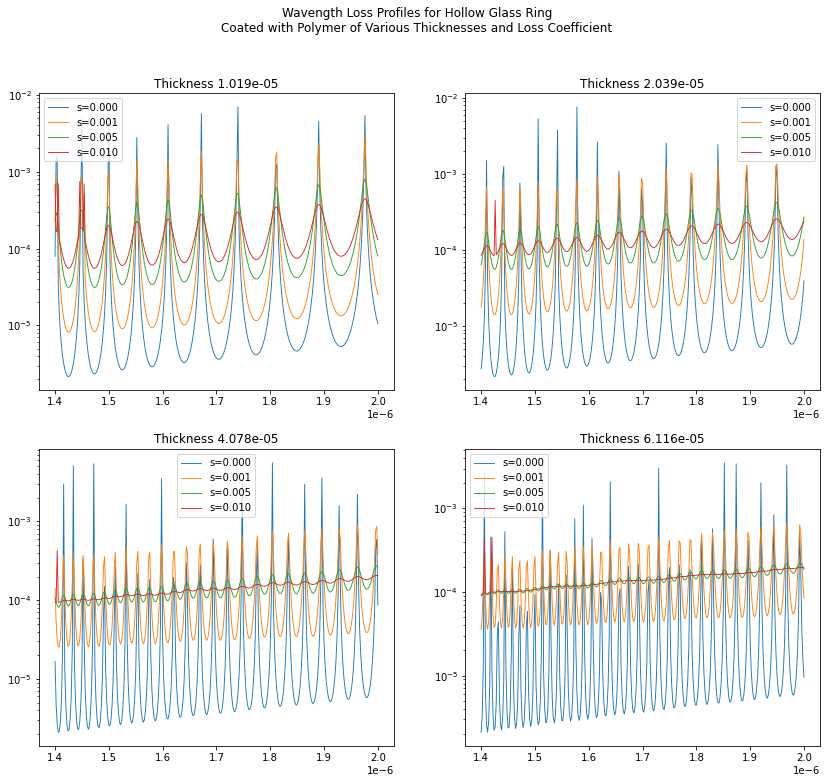

In [7]:
graph(results_loaded, Ds_loaded, Ss_loaded)

# How do loss and thickness relate?

Is there a quantity L we can define for each loss and thickness independent of wavelength?  We can test by seeing if we divide results across wavelengths we get the same number.

In [11]:
Ds_loaded, Ss_loaded

(array([1.019375e-05, 2.038750e-05, 4.077500e-05, 6.116250e-05]),
 array([0.   , 0.001, 0.005, 0.01 ]))

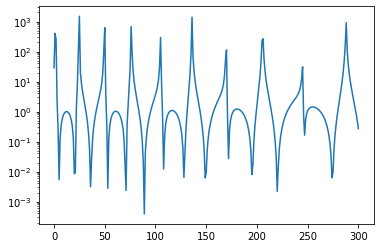

In [24]:
plt.plot(results_loaded[0,0].imag/results_loaded[1,0].imag)
plt.yscale('log')